# Setup the data

This notebook uses *slowfast* network to extract features of video clips.
documentation about the model can be found at:
https://pytorch.org/hub/facebookresearch_pytorchvideo_slowfast/

This model processes batches of 32 frames each 256x256 pixels, and outputs a vector of 400 probabilities each belonging to one class of kinetics-400 dataset.

The above code follows the model presented in the following paper:
[1] Christoph Feichtenhofer et al, “SlowFast Networks for Video Recognition” https://arxiv.org/pdf/1812.03982.pdf

<img src="files/1.png" width="600">

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the fish movie
data_path = '../../data/original_files/'

frames = np.loadtxt(data_path + 'frames.csv', delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)
print('frames.shape = {}'.format(frames.shape))

frames.shape = (1141, 120, 200)


In [3]:
# define a dataset object for the fish movie
class FishMovieDataset(Dataset):
    """Single frames of the fish movie"""

    def __init__(self, path, transform=None):
        """
        Input: path, nrn_i, transform
        path - path to where 'frames.csv' is stored
        transform - optional preprocessing on frames
        """
        
        frames = np.loadtxt(path + 'frames.csv', delimiter=',')
        frames = frames.reshape(frames.shape[0], 120, 200)
        
        self.frames = frames
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
            sample = self.frames[idx]
            if self.transform:
                sample = torch.stack([self.transform(Image.fromarray(frm)) for frm in sample])
                # sample shape is (T, C, H, W)
        
        else:
            sample = self.frames[idx]
            if self.transform:
                sample = self.transform(Image.fromarray(sample))
                # sample shape is (C, H, W)

        return sample
    
    def frame_sz(self):
        return self.frames.shape[1:]
    
    def num_frames(self):
        return self.frames.shape[0]

In [4]:
# Get fish movie dataset with preprocessed frames
fmdata = FishMovieDataset(path=data_path,
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(256),
                               torchvision.transforms.CenterCrop(256),
                               torchvision.transforms.ToTensor()
                           ]))

## Create batches of frames with a dataloader

Dataloader is a prepared torch object; however, I do not know how to create batches using negative indices with this method.

For exmaple, I may want to create a batch of 32 frames where the first 15 frames are frames[-15:0] and the remaining 17 frames are frames[0:17] (so, theoretically, I can write the whole batch as frames[-15:17]). But I do not know how to select part-batches using dataloader.

0 torch.Size([32, 1, 256, 256])
1 torch.Size([32, 1, 256, 256])
2 torch.Size([32, 1, 256, 256])
3 torch.Size([32, 1, 256, 256])


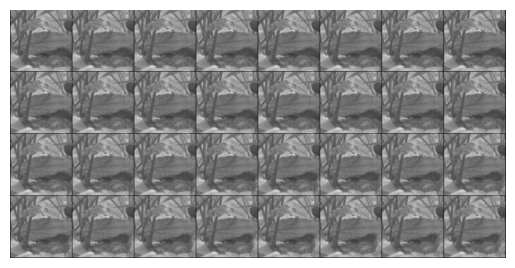

In [5]:
# iterate through batches of the movie of size 32 frames
dataloader = DataLoader(fmdata, batch_size=32,
                        shuffle=False, num_workers=0)


# Helper function to show a batch
def show_frames_batch(sample_batched):
    batch_size = len(sample_batched)
    im_size = sample_batched.size(2)
    grid_border_size = 2

    image_batched = torch.broadcast_to(sample_batched, (batch_size, 3, 256,256))/256
    grid = torchvision.utils.make_grid(image_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0. 

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_frames_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Create batches of frames withOUT a dataloader

Batch #0: contains 32 frames leading up to frame #0 (in other words, frames[-31:1])
<br>
...
<br>
Batch #31: contains 32 frames leading up to frame #31 (in other words, frames[0:32])

$\implies$ All in all, we have 1141 batches for 1141 frames.

0 torch.Size([32, 1, 256, 256])
frame indices:  tensor([ 969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,
         981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,  992,
         993,  994,  995,  996,  997,  998,  999, 1000], dtype=torch.int32)


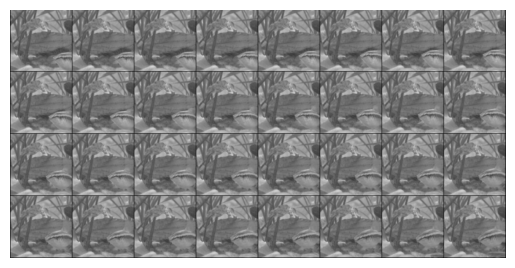

In [6]:
# idx = torch.tensor([1,3,3], dtype=torch.int32)
batch_ind = 1000
batch_sz = 32
idx = torch.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=torch.int32)
sample_batched = fmdata[idx]

print('0', sample_batched.size())
print('frame indices: ', idx)
plt.figure()
show_frames_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()

0 torch.Size([32, 1, 256, 256])
frame indices:  tensor([-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
          7,   8,   9,  10], dtype=torch.int32)


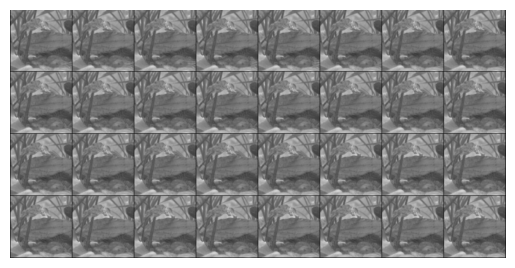

In [7]:
# another example with negative indices
batch_ind = 10
batch_sz = 32
idx = torch.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=torch.int32)
sample_batched = fmdata[idx]

print('0', sample_batched.size())
print('frame indices: ', idx)
plt.figure()
show_frames_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()

# Setup the model

In [8]:
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

import copy

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


In [9]:
# Load pretrained model
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in /home/yasamanparhizkar/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [10]:
# Set to GPU or CPU
device = 'cpu'
model = model.eval()
model = model.to(device)

In [11]:
# set model-specific parameters and transforms
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 1
frames_per_second = 60
slowfast_alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform = Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    )

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second


## Evaluate the model for some sample inputs

In [12]:
# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = next(iter(dataloader))
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# inputs is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [13]:
# Pass the input clip through the model
preds = model(inputs)
preds = preds.detach()

In [14]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

print(pred_classes)

tensor([ 23, 364,  66,  28, 299])


# Remove the top layers

In [15]:
# replace last fully connected layer with Identity
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [16]:
# copy the model so the original model doesn't change
model_t = copy.deepcopy(model)

# delete top layers
# model_t.blocks[5].dim = 0

model_t.blocks[6].dropout = Identity()
model_t.blocks[6].proj = Identity()
model_t.blocks[6].output_pool = Identity()

In [26]:
# print(model_t)

## Evaluate modified model (without the top layers)

In [32]:
# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = next(iter(dataloader))
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# inputs is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [33]:
# Pass the input clip through the model
preds_t = model_t(inputs)
preds_t = preds_t.detach()

In [48]:
preds_t.size()

torch.Size([1, 9216])

# Evaluate the modified model for all batches in the movie
# Alternative title: compute feature vectors

## Save feature vectors

In [49]:
bath_sz = 32
dataset_sz = len(fmdata)
# dataset_sz = 5

for batch_ind in range(dataset_sz):
    idx = torch.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=torch.int32)
    sample_batched = fmdata[idx]
    
    sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
    sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
    inputs = transform(sample_batched)
    inputs = [i.to(device)[None, ...] for i in inputs]
    
    preds = model_t(inputs)
    preds = preds.detach()
    torch.save(preds, '../../data/slowfast_9216/fv_'+str(batch_ind)+'.pt')
    # print(batch_ind, preds.size())

## Load feature vectors

In [16]:
# # load feature vectors - method 1
# fvs = []
# for vect_i in range(dataset_sz):
#     fvs.append(torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt'))

# fvs = torch.cat(fvs)

In [26]:
# # load feature vectors - method 2
# fvs = torch.cat([torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt') for vect_i in range(dataset_sz)])

# Align spike data with feature vectors

For all 297 repeats of the movie, return a pair of (feature vector, corresponding label) based on their extended index in the full dataset (aka all 297 repeats).

In [71]:
def get_datapoint(index, path, binned_data, neuron_id):
    """
    Return a datapoint consisting of (feature vector, label)
    based on the extended index system of the whole dataset (297 repeats of a 1141-frame movie).
    
    Inputs: index, path, binned_data, neuron_id
    index - index of the datapoint to be returned
            Note: this index indicates time. it must be between batch_sz-1 to 1141*297-1.
    path - path to where feature vectors are stored.
    binned_data - the original spike data of shape (297 x 1141 x 113)
    neuron_id - index of the selected neuron   
    
    Output: fv, lbl
    fv - 1x9216 torch tensor representing the feature vector of the selected time bin
    lbl - scalar corresponding spike label
    """
    
    fv = torch.load(path+'fv_'+str(index%1141)+'.pt')
    lbl = binned_data[index//1141,index%1141,neuron_id]
    
    return fv, lbl   

In [60]:
# get spike data
spikedata_path = '../../data/original_files/'
binned_data = np.loadtxt(data_path + 'spikes.csv', delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [72]:
# get the datapoint at frame 356 of the 297th repeat
# NOTE: index MUST be between batch_sz-1(= 31) to 1141*297-1(= 338876)
index = 296*1141+356
fv, lbl = get_datapoint(index, '../../data/slowfast_9216/', binned_data, I_order_10[0])
print(fv.shape)
print(lbl)

torch.Size([1, 9216])
0.0


# Use only the first layer of CNN

## Remove unnecessary layers from the model

In [ ]:
# remove all layers after the first layer
model_t.blocks[6] = Identity()
model_t.blocks[5] = Identity()
model_t.blocks[4] = Identity()
model_t.blocks[3] = Identity()
model_t.blocks[2] = Identity()
model_t.blocks[1] = Identity()
model_t.blocks[0].multipathway_fusion = Identity()

In [34]:
print(model_t)

Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): Identity()
    )
    (1): Identity()
    (2): Identity()
    (3): Identity()
    (4)

## Evaluate modified model (without the top layers)

In [84]:
# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = next(iter(dataloader))
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# inputs is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [85]:
# Pass the input clip through the model
preds_t = model_t(inputs)[1]  # first layer's output is a list of [slow pathway output, fast pathway output]
preds_t = preds_t.detach()

In [86]:
preds_t.size() # output size shape is (N_data, C, T, H, W)

torch.Size([1, 8, 32, 64, 64])

In [90]:
# subsample features for shorter length and flatten into a 1D vector
preds_t = preds_t[0, ::2, ::5, ::5, ::5].reshape(1, -1)

In [91]:
print('# features for each datapoint: ', preds_t.size())

# features for each datapoint:  torch.Size([1, 4732])


## Save all feature vectors extracted by the new model

In [76]:
bath_sz = 32
dataset_sz = len(fmdata)
# dataset_sz = 5

for batch_ind in range(dataset_sz):
    idx = torch.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=torch.int32)
    sample_batched = fmdata[idx]
    
    sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
    sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
    inputs = transform(sample_batched)
    inputs = [i.to(device)[None, ...] for i in inputs]
    
    preds = model_t(inputs)[1]
    preds = preds.detach()
    preds = preds[0, ::2, ::5, ::5, ::5].reshape(-1)
    torch.save(preds, '../../data/slowfast_4732/fv_'+str(batch_ind)+'.pt')
    # print(batch_ind, preds.size())